In [1]:
from gerrychain import Graph, Partition, GeographicPartition
from gerrychain.updaters import Tally, county_splits, boundary_nodes, cut_edges, cut_edges_by_part, exterior_boundaries, interior_boundaries, perimeter
import os

from custom_chain import CustomMarkovChain
from gerrychain.constraints import single_flip_contiguous, no_worse_L1_reciprocal_polsby_popper, districts_within_tolerance
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
import gerrychain.scores
from gerrychain import Election
from gerrychain.constraints.validity import deviation_from_ideal

import matplotlib.pyplot as plt

from collections import Counter
import numpy as np
import random

import time

from descartes import PolygonPatch



In [2]:
def generate_graph(path):
    return Graph.from_file(path)

#graph = generate_graph('Precincts2006Gen/Precincts2006Gen.shp')
#graph = generate_graph('SBE_PRECINCTS_09012012/SBE_PRECINCTS_09012012.shp')
#graph = generate_graph('SBE_PRECINCTS_20131004/PRECINCTS_20131004.shp')
#graph = generate_graph('NC-TRY-2015/PRECINCTS_20150918.shp')
#graph = generate_graph('NC-please/2016_Contingent_Congressional_Plan_Corrected.shp')
#graph = generate_graph('tl_2012_37_vtd10/tl_2012_37_vtd10.shp')


graph = generate_graph('PA_VTD.shp')

C:\Users\m\Anaconda3\envs\am207\lib\site-packages\gerrychain\graph\graph.py:193: UserWarning: Found leaves (degree-1 nodes, a.k.a. donuts). Indices of donuts: {1441, 1411, 2788, 2984, 169, 3792, 759, 1273, 63}
  donuts


In [3]:
graph.nodes[0]

{'boundary_node': False,
 'area': 58376433.46078541,
 'STATEFP10': '42',
 'COUNTYFP10': '039',
 'VTDST10': '60',
 'GEOID10': '42039060',
 'VTDI10': 'A',
 'NAME10': 'CAMBRIDGE SPRINGS Voting District',
 'NAMELSAD10': 'CAMBRIDGE SPRINGS Voting District',
 'LSAD10': '00',
 'MTFCC10': 'G5240',
 'FUNCSTAT10': 'N',
 'ALAND10': 2258229,
 'AWATER10': 0,
 'INTPTLAT10': '+41.8018353',
 'INTPTLON10': '-080.0596566',
 'ATG12D': 0.0,
 'ATG12R': 0.0,
 'GOV10D': 0.0,
 'GOV10R': 0.0,
 'PRES12D': 0.0,
 'PRES12O': 0.0,
 'PRES12R': 0.0,
 'SEN10D': 0.0,
 'SEN10R': 0.0,
 'T16ATGD': 0.0,
 'T16ATGR': 0.0,
 'T16PRESD': 0.0,
 'T16PRESOTH': 0.0,
 'T16PRESR': 0.0,
 'T16SEND': 0.0,
 'T16SENR': 0.0,
 'USS12D': 0.0,
 'USS12R': 0.0,
 'GOV': 3,
 'TS': 5,
 'HISP_POP': 0,
 'TOT_POP': 0,
 'WHITE_POP': 0,
 'BLACK_POP': 0,
 'NATIVE_POP': 0,
 'ASIAN_POP': 0,
 'F2014GOVD': 0,
 'F2014GOVR': 0,
 '2011_PLA_1': 3,
 'REMEDIAL_P': 14,
 '538CPCT__1': '03',
 '538DEM_PL': '03',
 '538GOP_PL': '03',
 '8THGRADE_1': '1',
 'geometry': <s

In [10]:
def run_simple(graph, steps=1000):
    election = Election(
        "2016 President",
        {"Democratic": "T16PRESD", "Republican": "T16PRESR"},
        alias="2016_President"
    )
    
    
    p2 = Partition(
            graph,
            assignment="2011_PLA_1",
            updaters={
                "2016_President": election,
                "population": Tally("TOT_POP", alias="population"), 
                "perimeter": perimeter,
                "exterior_boundaries": exterior_boundaries,
                "interior_boundaries": interior_boundaries,
                "boundary_nodes": boundary_nodes,
                "cut_edges": cut_edges,
                "area": Tally("area", alias="area"),
                "cut_edges_by_part": cut_edges_by_part, 
                "county_split" : county_splits( 'county_split', "COUNTYFP10"),
                "black_population": Tally("BLACK_POP", alias = "black_population"),
            
            }
        )


    efficiency_gaps = []
    wins = []
    waste_votes = []
    
    dummy_true = lambda x: True
    chain = CustomMarkovChain(
        proposal=propose_random_flip,
        is_valid=single_flip_contiguous,
        constraints=check_constraints,
        #constraints = dummy_true,
        accept=metro_scoring_prob, #THe acceptance criteria is what needs to be defined ourselves - to match the paper
        initial_state=p2,
        total_steps=steps
    )
    
    
    #return chain
    
    popwithin = 0
    poptotal = 0
    popthres = 1.005
    
    isowithin = 0
    isototal = 0
    isothres = 150
    
    bwithin = 0
    btotal = 0
    bratio1 = 0.55
    bratio2 = 0.3
    
    flip2ratio = 0
    flip2c = 0
    flipall = 0
    
    for partition in chain:
        
        
        populations = []
        for part in partition.parts:
            populations.append(partition['population'][part])
        for pop in populations:
            if pop > popthres * np.mean(populations):
                pass
            elif pop < (1. - (popthres-1.))* np.mean(populations):
                pass
            else:
                popwithin += 1
            poptotal += 1
        
        
        satisfied = True
        maxratio = 0
        for part in partition.parts:
            a, p = partition['area'][part], partition['perimeter'][part]
            if isoparametric(a, p) > maxratio:
                maxratio = isoparametric(a, p)
            if isoparametric(a, p) >= isothres:
                satisfied = False
        
        #print(maxratio)
        if satisfied:
            isowithin += 1
        isototal += 1
        
        satisfied = False
        bratios = []


        for part in partition.parts:
            bratio = partition['black_population'][part]/partition['population'][part]
            bratios.append(bratio)
        top2 = sorted(bratios, reverse=True)[:2]
        if top2[0] > bratio1 and top2[1] > bratio2:
            satisfied=True
        
        if satisfied:
            bwithin += 1
        btotal += 1
            
            
        
        
        info = county_split_score(partition, 'county_split')
        
        flat_list = [item for sublist in list(info.values()) for item in sublist]
        
        num_two = len(info[2])
        num_flips = len(flat_list)
        
        if num_two/num_flips > 0.72: #nearly always
            flip2ratio += 1
#         print(num_two/num_flips)
#         print(num_two)
        if num_two < 25:
            flip2c += 1
            
        flipall += 1
        
#         below_25 = 0
#         two_more_ratio = len(info[2])/(len(flat_list))
#         num_two = len(info[2])
#         num_flips = len(flat_list)
        
#         perM = []
#         for part in partition.parts:
#             perM.append(partition['black_population'][part]/partition['population'][part])
#         print(sorted(perM, reverse=True))
#         raise ValueError
        
        
  
#         scores = []
#         for part in partition.parts:
#             area, aperimeter = partition['area'][part], partition['perimeter'][part]
#             scores.append(isoparametric(area, aperimeter))
#         print(sorted(scores, reverse=True))
        
        efficiency_gaps.append(gerrychain.scores.efficiency_gap(partition["2016_President"]))
        wins.append(partition["2016_President"].wins("Democratic"))
        #waste_votes.append(gerrychain.scores.wasted_votes(np.sum(partition["2016_President"].votes("Democratic")),np.sum(partition["2016_President"].votes("Republican"))))
    print('percentage districtings within population threshold: {}%.'.format(popwithin/poptotal * 100.))
    print('percentage districtings with isoperimeter ratio within 150: {}%.'.format(isowithin/isototal * 100.))
    print('percentage districtings within minority requirements: {}%.'.format(bwithin/btotal * 100.))
    print('nearly always 2 county flips: {}%'.format(flip2ratio/flipall * 100))
    print('less than 25 2 county flips on average: {}%'.format(flip2c/flipall * 100))
    #print('nearly always 2 county flips : {}%.'.format(num_two/num_flips))

    return(efficiency_gaps, wins, partition)
    
    
   
#wp=3000, wi=2.5, wc=0.4, wm=800
#wp=0, wi=0, wc=0, wm=0
#before wc setting beta=0, wp=500, wi=1, wc=20, wm=0
def metro_scoring_prob(partition, beta=0, wp=4000, wi=17, wc=10, wm=0):
    #print(beta)
    #beta = 1 ####ONLY FOR FITTING WEIGHTS
    if(partition.parent == None):
        return True
    conflictedp = len(partition['cut_edges'])
    conflicted = conflictedp
    conflicted = len(partition.parent['cut_edges'])
    ratio = conflicted/conflictedp
    curr_score = score_partition(partition, wp, wi, wc, wm)
    prev_score = score_partition(partition.parent, wp, wi, wc, wm)
    exp = np.exp(-beta * (curr_score - prev_score))
    prob = min(1, ratio * exp)

    return(prob > random.random())

    

def check_constraints(partition):
    vra_req = True if vra_district_requirement(partition, thresholds = [0.55, 0.3]) == 0 else False
    #print([districts_within_tolerance_check(partition), isoparametric_score_check(partition), vra_req])
    return all([districts_within_tolerance_check(partition), isoparametric_score_check(partition), vra_req])

def districts_within_tolerance_check(partition, tol=1.02):
    populations = []
    for part in partition.parts:
        populations.append(partition['population'][part])
    populations = np.array(populations)
    if np.max(populations) > tol*np.mean(populations):
        return False
    if np.min(populations) < (1. - (tol-1.))*np.mean(populations):
        return False
    return True

# starts off with 299. smth for the largest.. we're already trying to bring it down :)
def isoparametric_score_check(partition, min_score=299):
    #scores = []
    for part in partition.parts:
        area, perimeter = partition['area'][part], partition['perimeter'][part]
        #print(isoparametric(area, perimeter))
        if isoparametric(area, perimeter) >= min_score:      
            #print(isoparametric(area, perimeter))
            return False
    return True
    
# #min_rank2 = 0.335, min_rank1 = 0.4
def minority_per_check(partition, min_rank2 = 0.335, min_rank1 = 0.4):
    per_minority = []
    for part in partition.parts:
        per_minority.append(partition['black_population'][part]/partition['population'][part])
    top2_per = sorted(per_minority)[-2:]
    #print(top2_per)
    if top2_per[1] > min_rank1 and top2_per[0] > min_rank2:
        return True
    else:
        return False
    
def score_partition(partition, wp, wi, wc, wm):
    return(equal_split_score(partition) * wp + compactness_split_score(partition) * wi+ 
           county_split_wrapper(partition) * wc + vra_district_requirement(partition) * wm)

# def score_partition(partition, wp, wi, wc, wm):
#     return(equal_split_score(partition) * wp + compactness_split_score(partition) * wi + vra_district_requirement(partition) * wm)

def vra_district_requirement(partition, num_districts = 2, thresholds = [0.589, 0.342]):
    if(len(thresholds) != num_districts):
        raise Exception("Number of thresholds needs to equal the number of districts you want")
    black_pop_dict = partition['black_population']
    total_dict = partition['population']
    fractions = Counter({k : black_pop_dict[k] / total_dict[k] for k in total_dict})
    #print(fractions)
    top_n = fractions.most_common(num_districts)
    thresholds.sort(reverse = True)
    #print(top_n)
    score = 0
#     print(top_n)
#     print(thresholds[:num_districts])
    for i in range(0, num_districts):
        #Get the max thresholds
        temp_score = max(0, thresholds[i] - top_n[i][1])
        score += np.sqrt(temp_score)
    return(score)
    
    
    
    
def isoparametric(area, perimeter):
    try:
        return (perimeter**2)/area
    except ZeroDivisionError:
        return np.nan

def polsby_popper(area, perimeter):
    try:
        return 4*np.pi*area / perimeter**2
    except ZeroDivisionError:
        return np.nan

def compact_dispersion(area, perimeter):
    raise NotImplementedError

def compactness_split_score(partition):
    isoparametric_parts = []
    #polsby_popper_parts = []
    #dispersion_parts = []
    for part in partition.parts:
        area, perimeter = partition['area'][part], partition['perimeter'][part]
        isoparametric_parts.append(isoparametric(area, perimeter))
        #polsby_popper_parts.append(polsby_popper(area, perimeter))
        #dispersion_parts.append()
    return np.sum(np.array(isoparametric_parts))
    #return np.array(polsby_popper_parts)
    #return np.array(dispersion_parts)

def equal_split_score(partition, population_name = 'population'):
    '''Take a partition and compute the root mean square deviance from a perfect equal split'''
    deviations = deviation_from_ideal(partition, population_name)
    score = np.linalg.norm(list(deviations.values()))
    return(score)
    
    
def county_split_wrapper(partition, county_split_name = 'county_split', district_name = 'county_split'):
    splits = county_split_score(partition, county_split_name)        
    
    score = compute_countySplitWeight(partition, splits, county_split_name, district_name)
    return(score)
    
def county_split_score(partition, county_split_name = 'county_split'):
    splits = partition[county_split_name]
    to_check = {}
    for s in splits:
        num_split = len(splits[s][2])
        if(num_split > 1):
            prev = to_check.get(num_split, [])
            prev.append(s)
            to_check[num_split] = prev
    return(to_check)

def compute_countySplitWeight(partition, info, county_split_name = 'county_split', district_name = "county_split"):
    '''Compute the county score function as described by the paper
    Takes in a parition with a county score_split data and computes the final 
    score'''
    two_counties = info[2]
    two_county_weight_sum = 0
    '''FIxme - should really combine both parts'''
    for c in two_counties:        
        nodes = partition[county_split_name][c][1]
        counties = [partition.assignment[n] for n in nodes]
        cn = Counter(counties)
        second_frac = cn.most_common(2)[1][1]/ sum(cn.values())
        two_county_weight_sum += np.sqrt(second_frac)
    
    three_plus_weight_sum = 0
    to_consider = list(info.keys())
    to_consider.remove(2)
    for count_counties in to_consider:
        counties_split_list = info[count_counties]
        for c in counties_split_list:
            nodes = partition[county_split_name][c][1]
            counties = [partition.assignment[n] for n in nodes]
            cn = Counter(counties)
            temp_frac = 0
            lst = cn.most_common()
            for i in range(2, len(lst)):
                temp_frac += lst[i][1]
            temp_frac = temp_frac / sum(cn.values())
            three_plus_weight_sum += np.sqrt(temp_frac)
    
    # Comput the 2 county split weight vs the 3 
    num_2 = len(two_counties)
    flat_list = [item for sublist in list(info.values()) for item in sublist]
    num_3plus = len(flat_list) - num_2
    # Says to use large number for three_plus_weight...
    final_score = two_county_weight_sum * num_2 + num_3plus * three_plus_weight_sum * 100
    if(final_score < 0):
        raise Exception("FInal weight should be less than 0")
    return(final_score)

def plot_state(partition):
    plt.figure()
    ax = plt.axes()
    colors = get_spaced_colors(len(partition.parts))
    nodes = partition.graph.nodes
    for n in nodes:
        data = partition.graph.nodes[n]
        poly = data['geometry']
        patch = PolygonPatch(poly, facecolor = colors[partition.assignment[n] - 1])
        ax.add_patch(patch)
        
    plt.xlim(-80.6, -74.5) #repsent longtitude
    plt.ylim(39, 42.5) # represent  lattitude

    plt.show()
        
    
def get_spaced_colors(n):
    '''from quora https://www.quora.com/How-do-I-generate-n-visually-distinct-RGB-colours-in-Python'''
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [(int(i[:2], 16)/256., int(i[2:4], 16)/256., int(i[4:], 16)/256.) for i in colors]

current conversion rate: 0.59475.
drew 9516 samples of requested 80000.
current conversion rate: 0.59425.
drew 11885 samples of requested 80000.
current conversion rate: 0.5841875.
drew 18694 samples of requested 80000.
current conversion rate: 0.5702272727272727.
drew 25090 samples of requested 80000.
current conversion rate: 0.5654230769230769.
drew 29402 samples of requested 80000.
current conversion rate: 0.561125.
drew 35912 samples of requested 80000.
current conversion rate: 0.5686578947368421.
drew 43218 samples of requested 80000.
current conversion rate: 0.5761125.
drew 46089 samples of requested 80000.
current conversion rate: 0.5886354166666666.
drew 56509 samples of requested 80000.
current conversion rate: 0.58697.
drew 58697 samples of requested 80000.
current conversion rate: 0.5818653846153846.
drew 60514 samples of requested 80000.
current conversion rate: 0.5770833333333333.
drew 62325 samples of requested 80000.
current conversion rate: 0.5644166666666667.
drew 6773

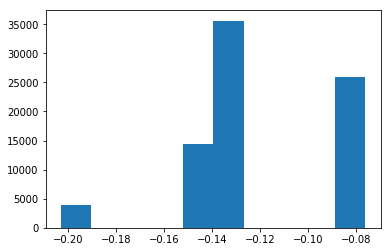

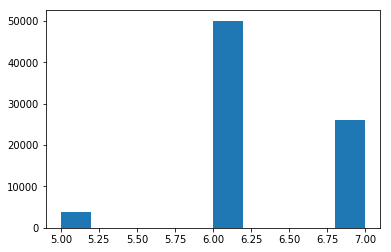

In [11]:
sTime = time.time()
#efficiency_gaps, wins, wasted_votes, partition = run_simple(graph, 80000)
efficiency_gaps, wins, partition = run_simple(graph, 80000)
print('{}s'.format(time.time() - sTime))
print(len(efficiency_gaps))
plt.hist(efficiency_gaps)
plt.show()
plt.hist(wins)
plt.show()
# plt.hist(wasted_votes)
# plt.show()

In [ ]:
# plt.hist([wv[0] for wv in wasted_votes])
# plt.show()
# plt.hist([wv[1] for wv in wasted_votes])
# plt.show()

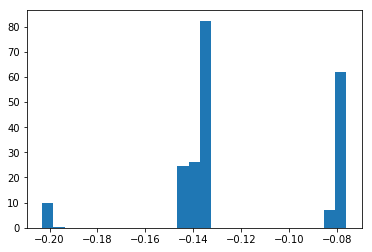

10524

In [12]:
plt.hist(efficiency_gaps, bins=27, density=True)
plt.show()
len(set(efficiency_gaps))

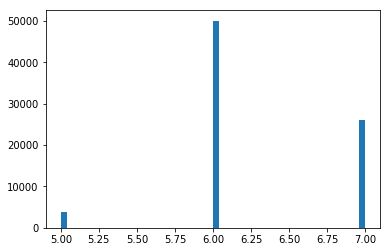

In [13]:
plt.hist(wins, bins=50)
plt.show()

In [ ]:
len(partition["2016_President"].votes("Democratic"))

In [ ]:
len(partition.parts)

In [ ]:
dir(partition)

In [ ]:
plot_state(partition)

In [ ]:
chain = run_simple(graph, 500)
for p in chain:
    print(p.accepted)
    #print(dir(p))
    print(dir(p.graph))
    raise ValueError

In [ ]:
%reset